In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer-ck-augmentedfer/ferckaugmentedfer.csv


In [2]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [3]:
data = pd.read_csv('/kaggle/input/fer-ck-augmentedfer/ferckaugmentedfer.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
# Process the third column to convert pixel strings to arrays
data['pixels'] = data[' pixels'].apply(lambda x: np.array(x.split(), dtype=np.float32) / 255.0)

In [5]:
# Select the second column (index 1) as the splitter column
splitter_column = data.iloc[:, 1]

In [6]:
# Split the dataset based on the values in the second column
train_data = data[splitter_column == 'Training']
validation_data = data[splitter_column == 'PublicTest']
test_data = data[splitter_column == 'PrivateTest']

In [7]:
# Preprocess the data (reshape and normalize)
def preprocess_data(data):
    images = np.array(data['pixels'].tolist()).reshape(-1, 48, 48, 1)
    return images

X_train = preprocess_data(train_data)
X_validation = preprocess_data(validation_data)
X_test = preprocess_data(test_data)

y_train = to_categorical(train_data['emotion'], num_classes=7)
y_validation = to_categorical(validation_data['emotion'], num_classes=7)
y_test = to_categorical(test_data['emotion'], num_classes=7)

In [8]:
# Create an image generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [9]:
print("Amount of data in the training set:")
print(train_datagen)

Amount of data in the training set:


In [10]:
def entry_flow(inputs):

  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x  # Set aside residual

  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for size in [128, 256, 728]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(  # Project residual
        size, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  return x

In [11]:
def middle_flow(x, num_blocks=8):

  previous_block_activation = x

  for _ in range(num_blocks):
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.add([x, previous_block_activation])  # Add back residual
    previous_block_activation = x  # Set aside next residual


  return x

In [12]:

def exit_flow(x, num_classes=7):

  previous_block_activation = x

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(728, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

  residual = layers.Conv2D(  # Project residual
      1024, 1, strides=2, padding='same')(previous_block_activation)
  x = layers.add([x, residual])  # Add back residual

  x = layers.SeparableConv2D(1536, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.SeparableConv2D(2048, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 1:
    activation = 'sigmoid'
  else:
    activation = 'softmax'
  return layers.Dense(num_classes, activation=activation, kernel_regularizer=regularizers.l2(0.01))(x)

inputs = keras.Input(shape=(48, 48, 1))  # Variable-size image inputs.
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = keras.Model(inputs, outputs)

In [13]:
#cnn = xception
xception.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 24, 24, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 24, 24, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 24, 24, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 24, 24, 64)     │         18,496 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 24, 24, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 24, 24, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 24, 24, 64)     │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 24, 24, 128)    │          8,896 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 24, 24, 128)    │            512 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 24, 24, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 24, 24, 128)    │         17,664 │ activation_3[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 24, 24, 128)    │            512 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 12, 12, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 12, 12, 128)    │          8,320 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 12, 12, 128)    │              0 │ max_pooling2d[0][0],   │
│                      

 Total params: 20,893,967 (79.70 MB)

 Trainable params: 20,843,711 (79.51 MB)

 Non-trainable params: 50,256 (196.31 KB)

In [14]:
# plot_model(xception, to_file='/content/drive/MyDrive/model.png', show_shapes=True, show_layer_names=True)

In [15]:
# Set up the optimizer
opt = tf.keras.optimizers.Adam(0.001)
xception.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
# Define ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('/kaggle/working/bestXceptionPlusData.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [17]:
# Train the model using the training and validation data with data augmentation
batch_size = 64
train_loader = train_datagen.flow(X_train, y_train, batch_size=batch_size)
validation_loader = (X_validation, y_validation)  # No data augmentation for validation

In [18]:
# Menampilkan jumlah data untuk setiap label
print("The amount of data in the training set:")
print(train_loader)

The amount of data in the training set:


In [19]:
# Fit the model using .fit
epochs = 50
h1 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                    validation_data=validation_loader, epochs=epochs, callbacks=[checkpoint])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1060/1060 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2669 - loss: 1.8988
Epoch 1: val_accuracy improved from -inf to 0.41293, saving model to /kaggle/working/bestXceptionPlusData.keras
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 130s 79ms/step - accuracy: 0.2670 - loss: 1.8987 - val_accuracy: 0.4129 - val_loss: 1.7654
Epoch 2/50
   1/1060 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.4062 - loss: 1.6546

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.41293
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - accuracy: 0.4062 - loss: 1.6546 - val_accuracy: 0.4121 - val_loss: 1.7543
Epoch 3/50
1059/1060 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4515 - loss: 1.4420
Epoch 3: val_accuracy improved from 0.41293 to 0.44915, saving model to /kaggle/working/bestXceptionPlusData.keras
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 58s 55ms/step - accuracy: 0.4515 - loss: 1.4419 - val_accuracy: 0.4492 - val_loss: 1.4932
Epoch 4/50
   1/1060 ━━━━━━━━━━━━━━━━━━━━ 54s 51ms/step - accuracy: 0.5156 - loss: 1.4645
Epoch 4: val_accuracy did not improve from 0.44915
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - accuracy: 0.5156 - loss: 1.4645 - val_accuracy: 0.4425 - val_loss: 1.5259
Epoch 5/50
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5101 - loss: 1.2963
Epoch 5: val_accuracy improved from 0.44915 to 0.50878, saving model to /kaggle/working/bestXceptionPlusData.keras
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 58s 5

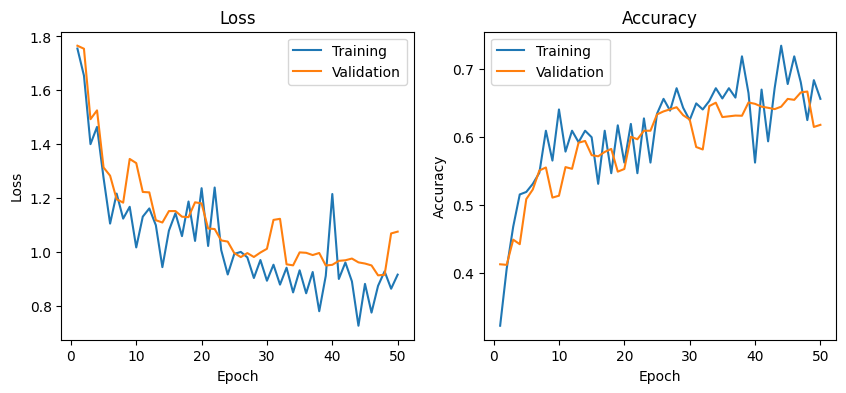

In [20]:
# Save history and view plots of loss and accuracy
history = h1.history
n_epochs = len(history['loss'])

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

In [21]:
# Ensure the model is compiled
if xception.optimizer is None:
    print("Model is not compiled yet. Compiling now...")
    xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy')

# Check the optimizer and learning rate type
print(f"Optimizer: {type(xception.optimizer)}")
print(f"Learning Rate Type: {type(xception.optimizer.learning_rate)}")

# Ensure the learning rate is a TensorFlow variable before updating
if isinstance(xception.optimizer.learning_rate, tf.Variable):
    tf.keras.backend.set_value(xception.optimizer.learning_rate, 0.0001)
else:
    xception.optimizer.learning_rate = tf.Variable(0.0001)

# Print updated learning rate
print(f"Updated Learning Rate: {xception.optimizer.learning_rate.numpy()}")

Optimizer: <class 'keras.src.optimizers.adam.Adam'>
Learning Rate Type: <class 'keras.src.backend.tensorflow.core.Variable'>
Updated Learning Rate: 9.999999747378752e-05


In [26]:
# save the model
xception.save("/kaggle/working/first_batch_xception.keras")

In [22]:
%%time
epochs = 30
# Training Run #2
h2 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                    validation_data=validation_loader, epochs = epochs, callbacks=[checkpoint])

Epoch 1/30
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7023 - loss: 0.8185
Epoch 1: val_accuracy improved from 0.66704 to 0.70075, saving model to /kaggle/working/bestXceptionPlusData.keras
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 57s 54ms/step - accuracy: 0.7023 - loss: 0.8184 - val_accuracy: 0.7008 - val_loss: 0.8231
Epoch 2/30
   1/1060 ━━━━━━━━━━━━━━━━━━━━ 54s 51ms/step - accuracy: 0.7031 - loss: 0.7938
Epoch 2: val_accuracy improved from 0.70075 to 0.70131, saving model to /kaggle/working/bestXceptionPlusData.keras
1060/1060 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7031 - loss: 0.7938 - val_accuracy: 0.7013 - val_loss: 0.8231
Epoch 3/30
   1/1060 ━━━━━━━━━━━━━━━━━━━━ 4:28 253ms/step - accuracy: 0.6875 - loss: 0.8297

KeyboardInterrupt: 

In [23]:
# Save history and view plots of loss and accuracy
for k in history.keys():
    history[k] += h2.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'h2' is not defined

In [ ]:
# # Update the learning rate
# tf.keras.backend.set_value(xception.optimizer.learning_rate, 0.00001)

# Ensure the model is compiled
if xception.optimizer is None:
    print("Model is not compiled yet. Compiling now...")
    xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy')

# Check the optimizer and learning rate type
print(f"Optimizer: {type(xception.optimizer)}")
print(f"Learning Rate Type: {type(xception.optimizer.learning_rate)}")

# Ensure the learning rate is a TensorFlow variable before updating
if isinstance(xception.optimizer.learning_rate, tf.Variable):
    tf.keras.backend.set_value(xception.optimizer.learning_rate, 0.00001)
else:
    xception.optimizer.learning_rate = tf.Variable(0.00001)

# Print updated learning rate
print(f"Updated Learning Rate: {xception.optimizer.learning_rate.numpy()}")

In [ ]:
%%time

# Training Run #3
epochs = 20
h3 = xception.fit(train_loader, steps_per_epoch=len(X_train) // batch_size,
                    validation_data=validation_loader, epochs=epochs, callbacks=[checkpoint])

In [ ]:
# Save history and view plots of loss and accuracy
for k in history.keys():
    history[k] += h3.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()